In [1]:
import os
import importlib
import numpy as np
from tqdm.auto import tqdm
#from plotnine import *
os.environ['OMP_NUM_THREADS'] = f'{os.cpu_count()//2}'
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray if imported

In [2]:
import ray

In [3]:
import importlib

In [4]:
import seesaw.dataset_manager
importlib.reload(seesaw.dataset_manager)

<module 'seesaw.dataset_manager' from '/home/gridsan/omoll/seesaw/seesaw/dataset_manager.py'>

In [5]:
import pandas as pd

In [6]:
import seesaw
import seesaw.vls_benchmark_tools
from seesaw import *
from seesaw.vls_benchmark_tools import *

In [7]:
evs = {}
benchresults = {}

In [8]:
ray.init('auto', namespace='seesaw', log_to_driver=False, ignore_reinit_error=True)
# model_actor = ray.remote(CLIPWrapper).options(name='clip', num_gpus=1., num_cpus=8.).remote(device='cuda:0')
# xclip = ModelService(ray.get_actor('clip'))
# for ev in evs.values():
#     ev.embedding = xclip
# xclip = ModelService(model_actor)

2021-12-03 15:12:54,388	INFO worker.py:822 -- Connecting to existing Ray cluster at address: 172.31.130.214:6379


{'node_ip_address': '172.31.130.214',
 'raylet_ip_address': '172.31.130.214',
 'redis_address': '172.31.130.214:6379',
 'object_store_address': '/tmp/omoll/raytmp/session_2021-12-03_15-09-56_283482_45684/sockets/plasma_store',
 'raylet_socket_name': '/tmp/omoll/raytmp/session_2021-12-03_15-09-56_283482_45684/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/omoll/raytmp/session_2021-12-03_15-09-56_283482_45684',
 'metrics_export_port': 45133,
 'node_id': 'eb10e2e7408be917c8f405fb4e0f638f2d20450d116342b2c27a2753'}

In [9]:
gdm = GlobalDataManager('/home/gridsan/omoll/seesaw_root/data')
ds_names = ['coco', 'bdd', 'objectnet', 'dota', 'lvis']

In [10]:
ac = ray.get_actor('clip#actor')

In [11]:
nodes = pd.DataFrame(ray.nodes())
nodes[nodes.Alive]

,NodeID,Alive,NodeManagerAddress,NodeManagerHostname,NodeManagerPort,ObjectManagerPort,ObjectStoreSocketName,RayletSocketName,MetricsExportPort,alive,Resources
0,eb10e2e7408be917c8f405fb4e0f638f2d20450d116342...,True,172.31.130.214,d-14-12-1,41553,42483,/tmp/omoll/raytmp/session_2021-12-03_15-09-56_...,/tmp/omoll/raytmp/session_2021-12-03_15-09-56_...,45133,True,"{'GPU': 2.0, 'object_store_memory': 1193604931..."


In [12]:
#ds_names = ['coco', 'bdd', 'objectnet', 'dota']
#gdm = GlobalDataManager('/home/gridsan/omoll/seesaw_data/data2')

# image_folders = {'coco':dict(base_dir='/home/gridsan/omoll/data/coco/'),
# 'bdd':dict(base_dir='/home/gridsan/omoll/data/bdd/bdd100k/images/100k/',prefixes=['train','val']),
# 'objectnet':dict(base_dir='/home/gridsan/omoll/data/objectnet/objectnet-1.0/cropped/'),
# 'dota':dict(base_dir='/home/gridsan/omoll/data/dota_dataset/')}

# for k in ds_names:
#     paths = list_image_paths(basedir=image_folders[k]['base_dir'], prefixes=image_folders[k].get('prefixes',['']))
#     gdm.create_dataset(image_src=image_folders[k]['base_dir'], dataset_name=k, paths=paths)

# for k in ds_names:
#     gdm.clone_subset(ds_name=k, 
#        file_names=np.load(f'/home/gridsan/omoll/seesaw_data/_scratch/seesaw_eval_data/{k}/sample_files_10k.npy', allow_pickle=True), 
#                      subset_name=f'{k}_10k')

#### run vector extraction script on each of those datasets


## rename coco -> coco_raw to remove extra files
#cds = gdm.get_dataset('coco_raw')
#qgt = pd.read_parquet(f'{cds.ground_truth_path()}/qgt.parquet')
#gdm.clone_subset(ds_name='coco_raw', subset_name='coco11', file_names=qgt.index)

## clone lvis from coco after vectors
#gdm.clone(ds_name='coco', clone_name='lvis')
#ds_names = ds_names + ['lvis']
#ds_names=['lvis']
## link each to ground truth
# for k in ds_names:
#      ds = gdm.get_dataset(k)
#      rt = ds.dataset_root
#      os.symlink(f'/home/gridsan/omoll/seesaw_data/_scratch/seesaw_eval_data/{k}', f'{rt}/ground_truth')

In [13]:
### image seen for first time
#### image inspected and marked as having nothing of interest => data = []
#### image inspected and marked with area of interest => [box0, box1,...]
#### data side: if marked with nothing. data = []

In [14]:
refs = []
dsorder = ['objectnet','lvis', 'dota', 'coco', 'bdd']
for k in tqdm(dsorder):
    ac = ray.get_actor(f'{k}#actor')
    evref = ray.get(ac.get_ev.remote())
    refs.append(evref)

  0%|          | 0/5 [00:00<?, ?it/s]

In [1]:
evs = dict(zip(dsorder, refs))
evs2 = {}
for (k,h) in evs.items():
    evs2[k] = ray.get(h)

NameError: name 'dsorder' is not defined

In [16]:
def genruns(goodcats, dataset, basedict,badcats):
    tups = []
    for category in goodcats:
        if category in badcats:
            continue
            
        initial_tup = {**basedict}
        initial_tup['dataset'] = dataset
        initial_tup['category'] = category
        initial_tup['qstr'] = category2query(dataset, category)#, category)
    
        for variant,tup in [
#       ('random', dict(warm_start='default', interactive='plain', qstr='nolang', fine_grained=False)), #random all the time
#       ('nolang_interactive', dict(warm_start='default', interactive='pytorch', qstr='nolang')), #random init, then learn
#       ('nolang_interactive_sklearn', dict(warm_start='default', interactive='sklearn', qstr='nolang')), #random init, then learn
#       ('interactive_sklearn', dict(warm_start='default',interactive='sklearn')),
#       ('interactive_pytorch_warm', dict(warm_start='warm', interactive='pytorch', fine_grained=False)),
#       ('interactive_pytorch_cold', dict(warm_start='default',interactive='pytorch', fine_grained=False)),
#       ('cosine_cold', dict(warm_start='default',interactive='pytorch', model_type='cosine')),
#      ('multiplain_warm_vec_fast', dict(warm_start='warm', interactive='pytorch', model_type='multirank2', 
#                                         granularity='multi', n_augment=None, positive_vector_type='vec_only')),

     ('multiplain_warm_vec_only_drop.10.2', dict(warm_start='warm', interactive='pytorch', model_type='cosine', 
                                          granularity='multi', n_augment=None, positive_vector_type='vec_only')),
#     ('multiplain_warm_vec_only', dict(warm_start='warm', interactive='pytorch', model_type='cosine', 
#                                           granularity='multi', n_augment=None, positive_vector_type='vec_only')),

#       ('multiplain_warm_both', dict(warm_start='warm', interactive='pytorch', model_type='cosine', granularity='multi', n_augment=5, positive_vector_type='image_and_vec')),
#       ('multiplain_warm_im_aug', dict(warm_start='warm', interactive='pytorch', model_type='cosine', granularity='multi', n_augment=5, positive_vector_type='image_only')),            ('multiplain_warm_im_only', dict(warm_start='warm', interactive='pytorch', model_type='cosine', granularity='multi', n_augment=1, positive_vector_type='image_only')),               
#       ('fine_grained_cosine_warm', dict(warm_start='warm', interactive='pytorch', model_type='cosine', granularity='fine')),
#       ('cosine_warm_multirank', dict(warm_start='warm', interactive='pytorch', model_type='multirank')),
#       ('fine_grained_direct', dict(warm_start='warm', interactive='pytorch', model_type='solver', fine_grained=True)),
#      ('multiplain', dict(warm_start='default', interactive='plain', granularity='multi', n_augment=None, positive_vector_type=None)),
#       ('plain', dict(warm_start='default', interactive='plain', granularity='coarse', n_augment=None, positive_vector_type=None)),
#       ('fine_grained_plain', dict(warm_start='default', interactive='plain', granularity='fine')),
#       ('multi_grained_plain', dict(warm_start='default', interactive='plain',  fine_grained='multi')),
        ]:
            rtup = {'variant':variant}
            rtup.update(initial_tup)
            rtup.update(tup)
            tups.append(rtup)
    return tups

def make_tups(evs, dsnames, cats='all', irange='all', shuffle=False):
    tups = []
    for k in dsnames:
        if cats == 'all':
            good_cats = evs[k].query_ground_truth.columns.values
            sums = evs[k].query_ground_truth.sum()
            good_cats = sums[sums > 0].index.values
        else:
            good_cats=cats
            
        if shuffle:
            random.shuffle(good_cats)

        if irange != 'all':
            good_cats = good_cats[irange[0]:irange[1]]
            
        print(good_cats)

        
#        good_cats = ['snowy weather', 'bike']
        #good_cats = ['sling (bandage)', 'manatee', 'popsicle','soup bowl']
        qtups = genruns(good_cats, dataset=k, basedict={
            'dataset_variant':k,
            'n_batches':10, #20 
            'batch_size':10, #10
            'minibatch_size':10,
#             'max_feedback':20,
            'max_feedback':None,
            'learning_rate':.005,
#             'steps_per_update':30
            'box_drop_prob':.10,
            'num_epochs':2,
            'solver_opts':{
                'C':.1,
                'max_examples':225,
                'loss_margin':.05},
            'cosine_opts':{
                'max_examples':225,
                'loss_margin':.05,
                'num_epochs':2
            },
            'tqdm_disabled':True,
            'loss_margin':.1,
            'max_examples':500
        },
#                         badcats=['clarinet']
                       badcats=['clarinet'])
        
        tups.extend(qtups)
     
    
    if shuffle:
        random.shuffle(tups)
    return tups


In [80]:
tups5 = make_tups(evs=evs2, dsnames=list(evs2.keys()), cats='all', shuffle=True)

['placemat' 'oven mitts' 'trash bin' 'drying rack for plates' 'rake'
 'helmet' 'usb cable' 'boots' 'cd case' 'paintbrush' 'coffee beans'
 'power bar' 'measuring cup' 'honey container' 'letter opener' 'fork'
 'dvd player' 'tarp' 'vase' 't-shirt' 'soap bar' 'teapot' 'lettuce'
 'eyeglasses' 'raincoat' 'earbuds' 'wine glass' 'receipt' 'plastic bag'
 'power cable' 'lemon' 'vacuum cleaner' 'necklace' 'chopstick'
 'baking sheet' 'candle' 'portable heater' 'wallet' 'water bottle'
 'tape / duct tape' 'standing lamp' 'bookend' 'first aid kit' 'cellphone'
 'pet food container' 'strainer' 'newspaper' 'bread knife' 'nail polish'
 'still camera' 'wok' 'whisk' 'broom' 'night light' 'drinking cup'
 'clothes hamper' 'desk lamp' 'plastic cup' 'pitcher' 'glue container'
 'cellphone charger' 'bike pump' 'skirt' 'drawer (open)' 'tanktop' 'ladle'
 'watch' 'shampoo bottle' 'drinking straw' 'suit jacket' 'deodorant'
 'headphones (over ear)' 'pop can' 'paint can' 'toilet paper roll'
 'handbag' 'pillow' 'usb fl

In [83]:
num_workers = 50
ray.available_resources()['memory']/(2**30)/num_workers, ray.available_resources()['CPU']/num_workers

(5.001347835548222, 0.72)

In [86]:
ray.available_resources()

{'CPU': 36.0,
 'memory': 268507817370.0,
 'accelerator_type:V100': 1.0,
 'node:172.31.130.214': 0.98,
 'object_store_memory': 71647892308.0,
 'GPU': 1.0}

In [30]:
importlib.reload(seesaw.figures)
importlib.reload(seesaw.search_loop_models)
importlib.reload(seesaw.pairwise_rank_loss)
importlib.reload(seesaw.vls_benchmark_tools)
from seesaw import *
from seesaw.figures import *

In [31]:
actors = make_bench_actors(evs, num_actors=num_workers, resources=dict(num_cpus=2, memory=8*(2**30)))
hs = []
for a in actors:
    hs.append(a.ready.remote())
_ = ray.get(hs)

In [81]:
for a in actors:
    ray.kill(a)

In [45]:
#

In [56]:
# hello 1= 1

In [70]:
2*3

6

In [69]:
1 + 1

2

In [79]:
##

In [32]:
results1010_drop102 = []
parallel_run(evs=evs, actors=actors, tups=tups5, benchresults=results1010_drop102)

new run


  0%|          | 0/194 [00:00<?, ?it/s]

done with new tups


In [48]:
10

10

In [50]:
#print')

In [51]:
1 + 1

2

In [34]:
stats_drop25102, _ = process_tups(results1010_drop102, at_N=100)

  0%|          | 0/194 [00:00<?, ?it/s]

In [36]:
1

1

In [26]:
stats_drop25102, _ = process_tups(results1010_drop252 + results1010_drop10 + results1010_drop102 + results1010_drop25, at_N=100)

NameError: name 'results1010_drop252' is not defined

In [56]:
nstats = stats_drop25102 #pd.concat([stats_drop25, stats_drop01, stats])
for variant in [ 'multiplain_warm_vec_only_drop.10.2', 'multiplain_warm_vec_only_drop.25.2']:
    print_tables(nstats,variant=variant)

by dataset


,multiplain,multiplain_warm_vec_only_drop.10,multiplain_warm_vec_only_drop.10.2,multiplain_warm_vec_only_drop.25,multiplain_warm_vec_only_drop.25.2,plain,num_queries
dataset,,,,,,,
bdd,0.729821,0.802994,0.800929,0.793654,0.786647,0.722601,29
coco,0.920811,0.946062,0.944689,0.941264,0.931762,0.861299,80
dota,0.744009,0.851269,0.848128,0.849881,0.838349,0.609752,15
lvis,0.709576,0.768020,0.767932,0.762714,0.763882,0.618615,1202
objectnet,0.407760,0.479229,0.480069,0.466039,0.462251,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,13,14,2,29
coco,22,57,1,80
dota,11,4,0,15
lvis,761,406,35,1202
objectnet,208,100,5,313
total,1015,581,43,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      13 &    14 &      2 &     29 \\
coco      &      22 &    57 &      1 &     80 \\
dota      &      11 &     4 &      0 &     15 \\
lvis      &     761 &   406 &     35 &   1202 \\
objectnet &     208 &   100 &      5 &    313 \\
total     &    1015 &   581 &     43 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.15,.43,.83
ratio,3.22,2.43,1.15


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .15 &  .43 &  .83 \\
ratio     & 3.22 & 2.43 & 1.15 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.35,.17,.76,.05
+ feedback fusion,.15,.07,.43,.08,.83,.06


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .35 &       .17 & .76 &       .05 \\
+ feedback fusion   & .15 &       .07 & .43 &       .08 & .83 &       .06 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.081066,0.034642,0.346064,0.170676,0.763686,0.045771
+ feedback fusion,0.149388,0.068323,0.425705,0.079641,0.827191,0.063504


by dataset


,multiplain,multiplain_warm_vec_only_drop.10,multiplain_warm_vec_only_drop.10.2,multiplain_warm_vec_only_drop.25,multiplain_warm_vec_only_drop.25.2,plain,num_queries
dataset,,,,,,,
bdd,0.729821,0.802994,0.800929,0.793654,0.786647,0.722601,29
coco,0.920811,0.946062,0.944689,0.941264,0.931762,0.861299,80
dota,0.744009,0.851269,0.848128,0.849881,0.838349,0.609752,15
lvis,0.709576,0.768020,0.767932,0.762714,0.763882,0.618615,1202
objectnet,0.407760,0.479229,0.480069,0.466039,0.462251,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,12,13,4,29
coco,22,56,2,80
dota,11,4,0,15
lvis,746,420,36,1202
objectnet,184,118,11,313
total,975,611,53,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      12 &    13 &      4 &     29 \\
coco      &      22 &    56 &      2 &     80 \\
dota      &      11 &     4 &      0 &     15 \\
lvis      &     746 &   420 &     36 &   1202 \\
objectnet &     184 &   118 &     11 &    313 \\
total     &     975 &   611 &     53 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.14,.40,.82
ratio,3.05,2.25,1.14


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .14 &  .40 &  .82 \\
ratio     & 3.05 & 2.25 & 1.14 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.35,.17,.76,.05
+ feedback fusion,.14,.06,.40,.05,.82,.05


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .35 &       .17 & .76 &       .05 \\
+ feedback fusion   & .14 &       .06 & .40 &       .05 & .82 &       .05 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.081066,0.034642,0.346064,0.170676,0.763686,0.045771
+ feedback fusion,0.141601,0.060536,0.395077,0.049013,0.817408,0.053722


In [135]:
sbs = side_by_side_comparison(stats, 'plain', metric='ndcg_score')

In [137]:
sbs2 = sbs[(sbs.variant == variant)][['dataset', 'category', 'ndcg_score', 'base_ndcg_score', 'nfirst_x', 'nfirst_y', 'nfound_x', 'nfound_y']]

In [141]:
sbs2[(sbs2.ndcg_score > 0) & (sbs2.base_ndcg_score == 0)].shape

(17, 8)

In [142]:
sbs2[(sbs2.ndcg_score == 0) & (sbs2.base_ndcg_score > 0)]

,dataset,category,ndcg_score,base_ndcg_score,nfirst_x,nfirst_y,nfound_x,nfound_y
376,lvis,file (tool),0.0,0.072110,inf,90.0,0,1
936,lvis,tambourine,0.0,0.099377,inf,71.0,0,1
1104,lvis,pan (metal container),0.0,0.041551,inf,67.0,0,1
1595,lvis,gag,0.0,0.064822,inf,64.0,0,1
4370,lvis,breechcloth,0.0,0.102977,inf,61.0,0,1


by dataset


,multiplain,multiplain_warm_vec_only,plain,num_queries
dataset,,,,
bdd,0.729821,0.811211,0.722601,29
coco,0.920811,0.951850,0.861299,80
dota,0.744009,0.853194,0.609752,15
lvis,0.709576,0.771799,0.618615,1202
objectnet,0.407760,0.486553,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,13,13,3,29
coco,23,57,0,80
dota,11,4,0,15
lvis,764,405,33,1202
objectnet,226,84,3,313
total,1037,563,39,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      13 &    13 &      3 &     29 \\
coco      &      23 &    57 &      0 &     80 \\
dota      &      11 &     4 &      0 &     15 \\
lvis      &     764 &   405 &     33 &   1202 \\
objectnet &     226 &    84 &      3 &    313 \\
total     &    1037 &   563 &     39 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.15,.41,.84
ratio,3.22,2.33,1.16


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .15 &  .41 &  .84 \\
ratio     & 3.22 & 2.33 & 1.16 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.35,.17,.76,.05
+ feedback fusion,.15,.07,.41,.06,.84,.07


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .35 &       .17 & .76 &       .05 \\
+ feedback fusion   & .15 &       .07 & .41 &       .06 & .84 &       .07 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.081066,0.034642,0.346064,0.170676,0.763686,0.045771
+ feedback fusion,0.149694,0.068628,0.408428,0.062364,0.835254,0.071567


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


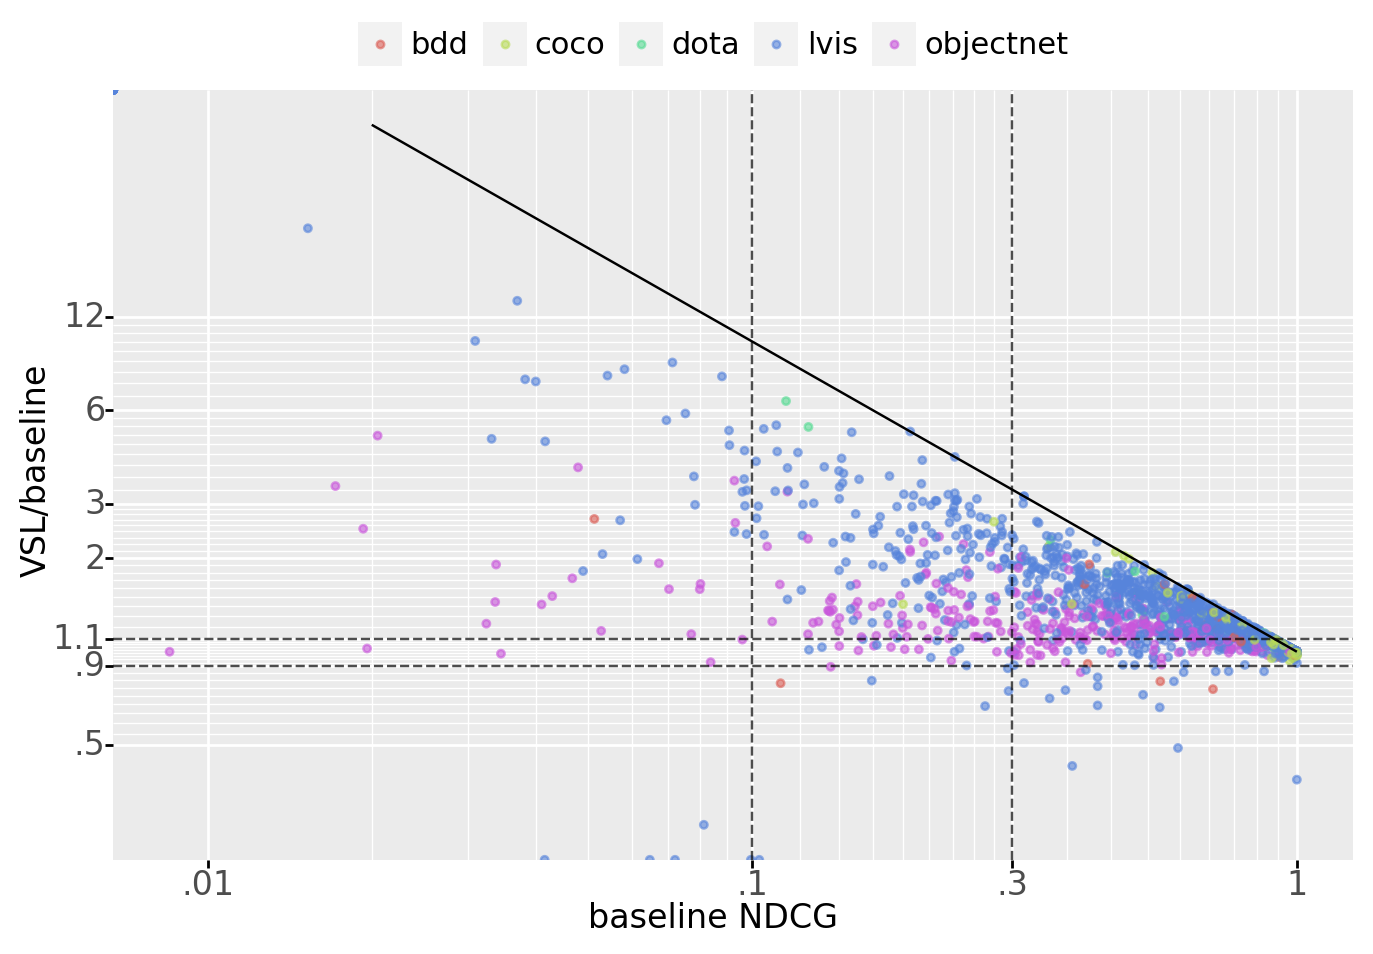

<ggplot: (8736941471196)>

In [66]:
variant='multiplain_warm_vec_only'
print_tables(stats,variant=variant)

In [100]:
stats100_objnet_lrsmall,_ = process_tups(results_on1, at_N=100)

  0%|          | 0/939 [00:00<?, ?it/s]

by dataset


,multiplain,multiplain_warm_vec_fast,plain,num_queries
dataset,,,,
objectnet,0.407704,0.399288,0.40766,313


by query


,better,same,worse,total
dataset,,,,
objectnet,62,156,95,313
total,62,156,95,313


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
objectnet &      62 &   156 &     95 &    313 \\
total     &      62 &   156 &     95 &    313 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  313.0


part,.1,.3,1.
variant,,,
counts,23,87,203
baseline,.05,.20,.54
this work,.07,.22,.51
ratio,1.31,1.08,.96


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &  1. \\
variant   &      &      &     \\
\midrule
counts    &   23 &   87 & 203 \\
baseline  &  .05 &  .20 & .54 \\
this work &  .07 &  .22 & .51 \\
ratio     & 1.31 & 1.08 & .96 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.20,NaN,.54,NaN
+ multiscale search,.05,.00,.20,.00,.54,-0.00
+ feedback fusion,.07,.02,.22,.02,.51,-0.02


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .20 &       NaN & .54 &       NaN \\
+ multiscale search & .05 &       .00 & .20 &       .00 & .54 &     -0.00 \\
+ feedback fusion   & .07 &       .02 & .22 &       .02 & .51 &     -0.02 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.051806,NaN,0.203579,NaN,0.535442,NaN
+ multiscale search,0.051848,0.000041,0.203809,0.000230,0.535406,-0.000036
+ feedback fusion,0.067767,0.015919,0.219688,0.015879,0.513821,-0.021585


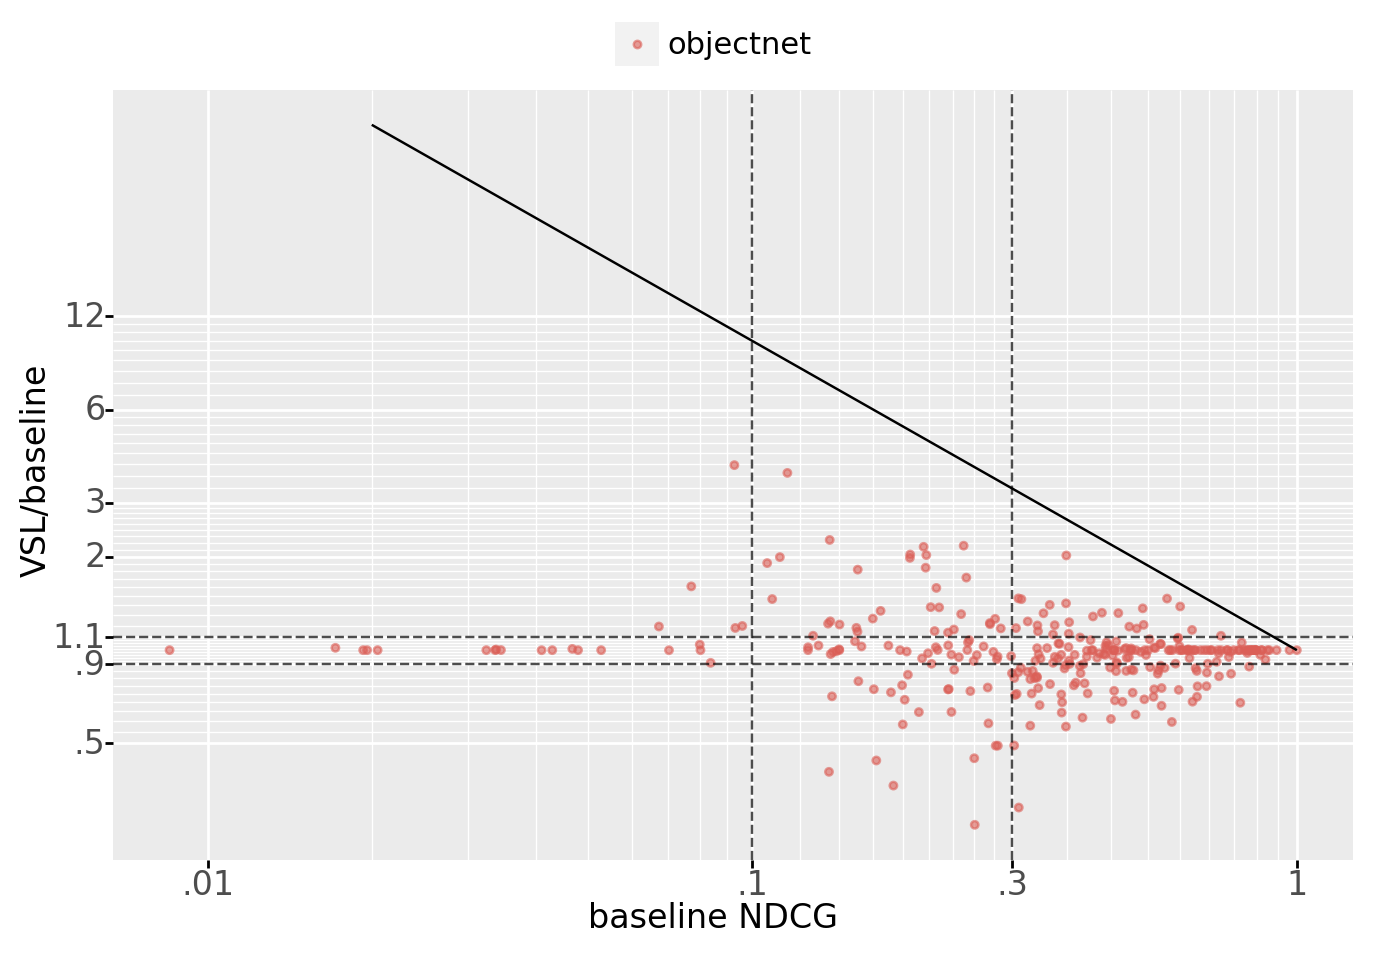

<ggplot: (8776775036603)>

In [101]:
print_tables(stats100_objnet_lrsmall, variant='multiplain_warm_vec_fast')

In [80]:
stats100_feedback10,_ = process_tups(new_results, at_N=100)

  0%|          | 0/4917 [00:00<?, ?it/s]

by dataset


,multiplain,multiplain_warm_vec_fast,plain,num_queries
dataset,,,,
bdd,0.721451,0.803383,0.722601,29
coco,0.915720,0.934494,0.861299,80
dota,0.730835,0.822013,0.609752,15
lvis,0.710103,0.762265,0.618615,1202
objectnet,0.407704,0.398443,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,14,11,4,29
coco,23,55,2,80
dota,10,4,1,15
lvis,737,418,47,1202
objectnet,63,150,100,313
total,847,638,154,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      14 &    11 &      4 &     29 \\
coco      &      23 &    55 &      2 &     80 \\
dota      &      10 &     4 &      1 &     15 \\
lvis      &     737 &   418 &     47 &   1202 \\
objectnet &      63 &   150 &    100 &    313 \\
total     &     847 &   638 &    154 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.10,.41,.80
ratio,2.13,2.32,1.11


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .10 &  .41 &  .80 \\
ratio     & 2.13 & 2.32 & 1.11 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.34,.17,.76,.04
+ feedback fusion,.10,.02,.41,.06,.80,.04


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .34 &       .17 & .76 &       .04 \\
+ feedback fusion   & .10 &       .02 & .41 &       .06 & .80 &       .04 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.078106,0.031682,0.342036,0.166647,0.758326,0.040411
+ feedback fusion,0.098766,0.020660,0.406693,0.064658,0.799599,0.041273


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


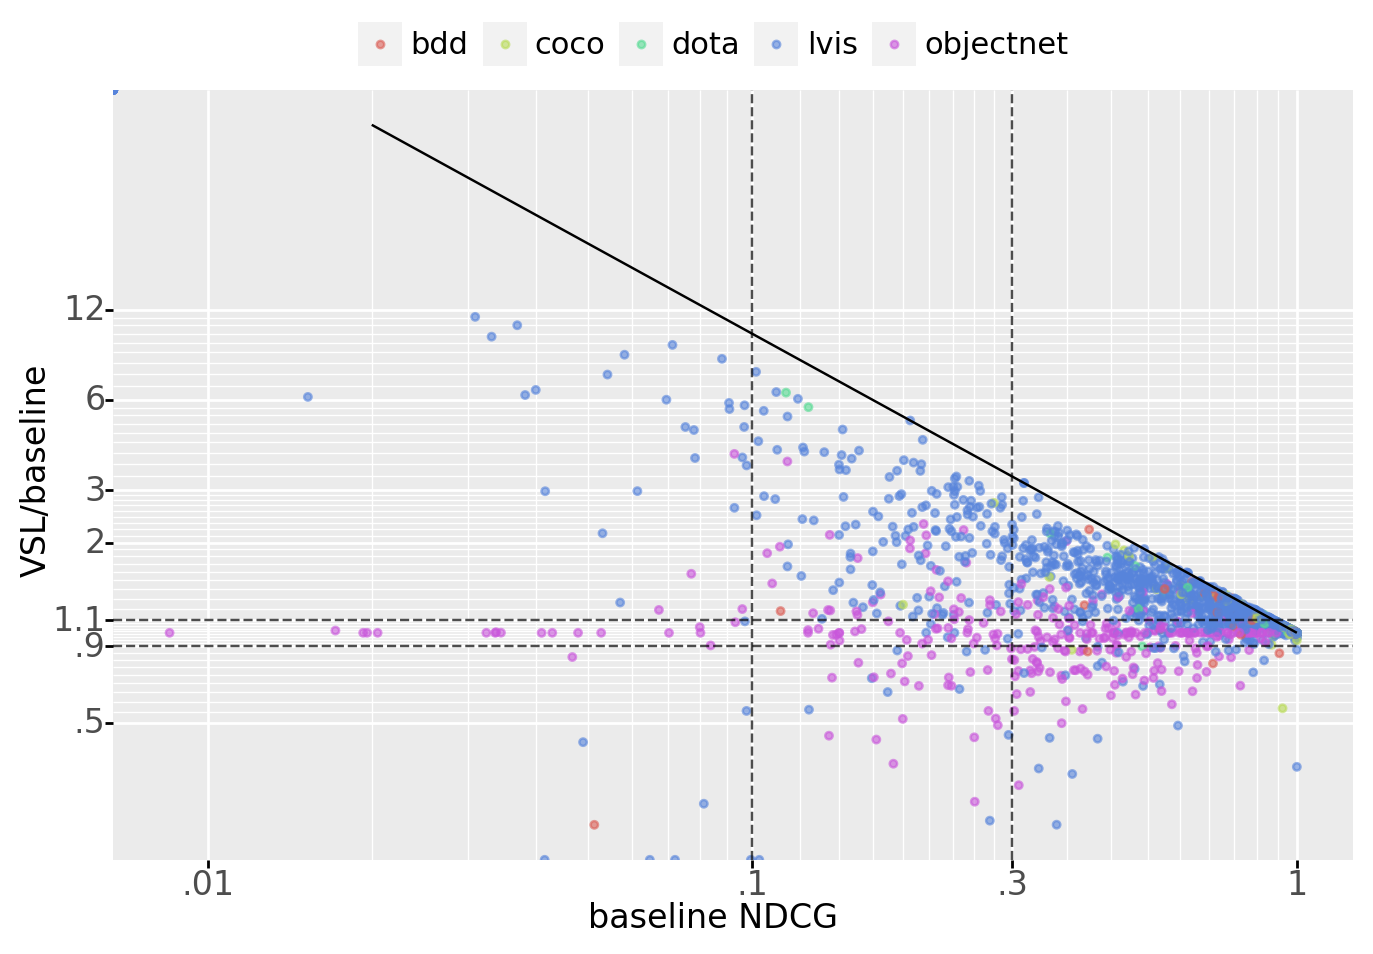

<ggplot: (8776778749877)>

In [81]:
print_tables(stats100_feedback10, variant='multiplain_warm_vec_fast')

In [104]:
#stats100_feedback10

,ntotal,nfound,ndcg_score,ndatabase,abundance,nframes,nfirst,reciprocal_rank,at_N,dataset,variant,category,qstr,dataset_variant,run_id
0,1,1,0.270238,209,0.004785,100,12.0,0.083333,100,lvis,plain,cooker,cooker,lvis,0
1,1,1,0.315465,227,0.004405,100,8.0,0.125000,100,lvis,plain,cockroach,cockroach,lvis,1
2,3,3,1.000000,429,0.006993,100,1.0,1.000000,100,lvis,plain,grits,grits,lvis,2
3,2,2,0.877215,310,0.006452,100,1.0,1.000000,100,lvis,plain,houseboat,houseboat,lvis,3
4,1,1,0.183169,223,0.004484,100,43.0,0.023256,100,lvis,plain,clippers (for plants),clippers for plants,lvis,4


by dataset


,multiplain,multiplain_warm_vec_fast,plain,num_queries
dataset,,,,
bdd,0.748749,0.820606,0.753351,29
coco,0.939437,0.957715,0.900086,80
dota,0.824192,0.925029,0.710243,15
lvis,0.717486,0.774859,0.616601,1202
objectnet,0.532905,0.587038,0.532610,313


by query


,better,same,worse,total
dataset,,,,
bdd,13,12,4,29
coco,20,58,2,80
dota,10,5,0,15
lvis,706,460,36,1202
objectnet,131,139,43,313
total,880,674,85,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      13 &    12 &      4 &     29 \\
coco      &      20 &    58 &      2 &     80 \\
dota      &      10 &     5 &      0 &     15 \\
lvis      &     706 &   460 &     36 &   1202 \\
objectnet &     131 &   139 &     43 &    313 \\
total     &     880 &   674 &     85 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,132,218,1289
baseline,.03,.22,.78
this work,.20,.50,.87
ratio,6.24,2.3,1.11


\begin{tabular}{lrrr}
\toprule
part &   .1 &  .3 &   1. \\
variant   &      &     &      \\
\midrule
counts    &  132 & 218 & 1289 \\
baseline  &  .03 & .22 &  .78 \\
this work &  .20 & .50 &  .87 \\
ratio     & 6.24 & 2.3 & 1.11 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.03,NaN,.22,NaN,.78,NaN
+ multiscale search,.09,.06,.42,.20,.82,.03
+ feedback fusion,.20,.10,.50,.09,.87,.05


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .03 &       NaN & .22 &       NaN & .78 &       NaN \\
+ multiscale search & .09 &       .06 & .42 &       .20 & .82 &       .03 \\
+ feedback fusion   & .20 &       .10 & .50 &       .09 & .87 &       .05 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.031575,NaN,0.219541,NaN,0.783150,NaN
+ multiscale search,0.092277,0.060702,0.415632,0.196090,0.817497,0.034347
+ feedback fusion,0.197008,0.104731,0.504803,0.089171,0.868054,0.050557


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 31 rows containing missing values.


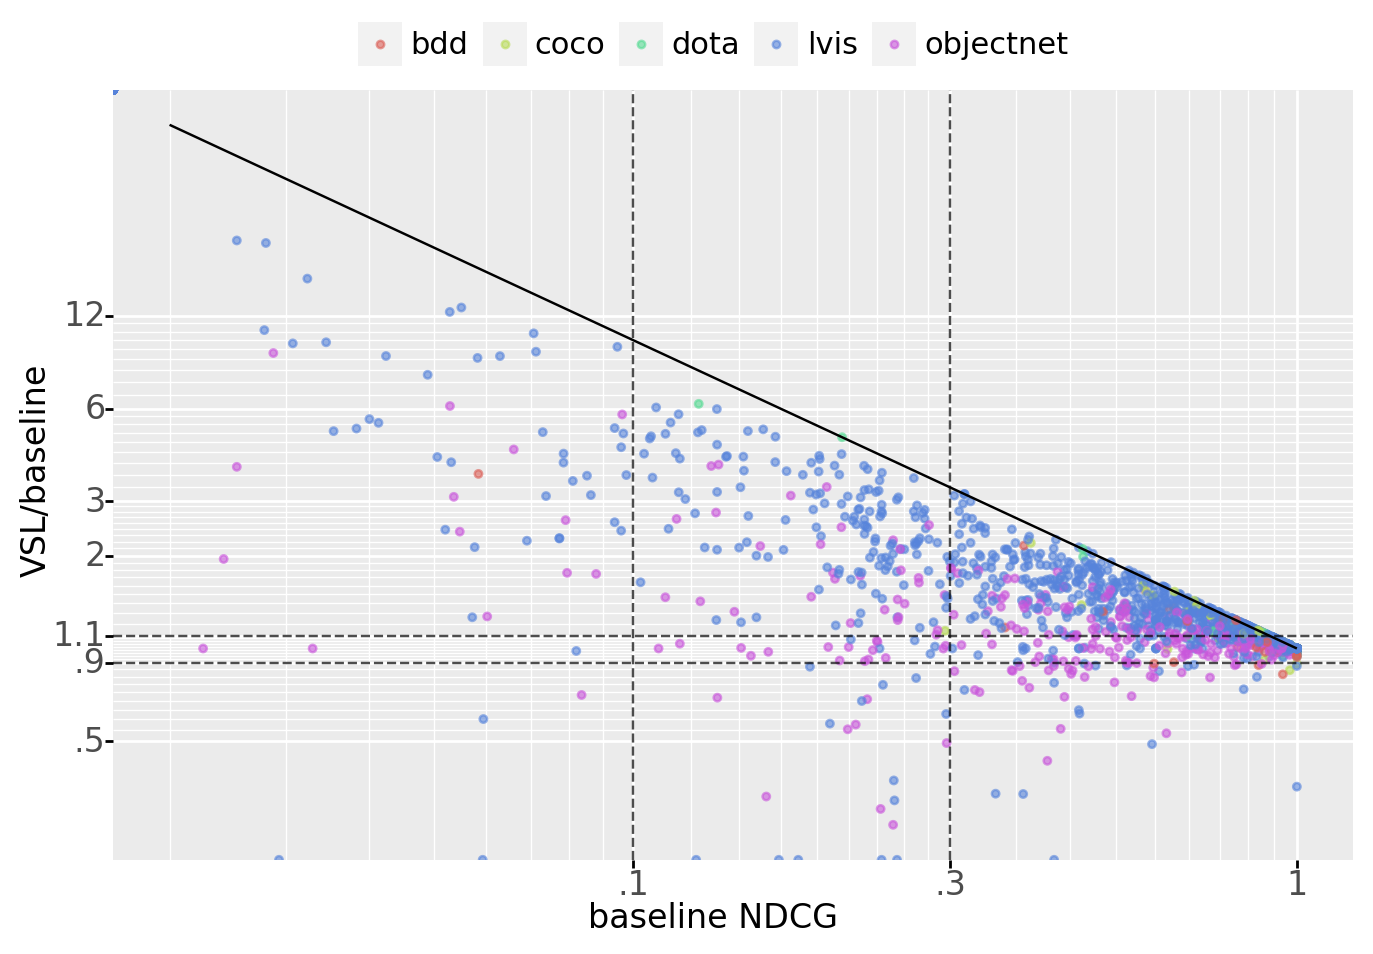

<ggplot: (8776776978719)>

In [61]:
print_tables(stats30, variant='multiplain_warm_vec_fast')

by dataset


,multiplain,multiplain_warm_vec_fast,plain,num_queries
dataset,,,,
bdd,0.720637,0.821003,0.722166,29
coco,0.914706,0.956497,0.860259,80
dota,0.727555,0.855507,0.607383,15
lvis,0.710137,0.799115,0.619526,1202
objectnet,0.405384,0.502266,0.405522,313


by query


,better,same,worse,total
dataset,,,,
bdd,16,11,2,29
coco,23,57,0,80
dota,12,3,0,15
lvis,797,374,31,1202
objectnet,210,73,30,313
total,1058,518,63,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      16 &    11 &      2 &     29 \\
coco      &      23 &    57 &      0 &     80 \\
dota      &      12 &     3 &      0 &     15 \\
lvis      &     797 &   374 &     31 &   1202 \\
objectnet &     210 &    73 &     30 &    313 \\
total     &    1058 &   518 &     63 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,85,247,1307
baseline,.05,.17,.72
this work,.23,.45,.84
ratio,5.08,2.59,1.17


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   85 &  247 & 1307 \\
baseline  &  .05 &  .17 &  .72 \\
this work &  .23 &  .45 &  .84 \\
ratio     & 5.08 & 2.59 & 1.17 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.17,NaN,.72,NaN
+ multiscale search,.08,.03,.34,.17,.76,.04
+ feedback fusion,.23,.16,.45,.11,.84,.08


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .17 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .34 &       .17 & .76 &       .04 \\
+ feedback fusion   & .23 &       .16 & .45 &       .11 & .84 &       .08 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046127,NaN,0.174037,NaN,0.716454,NaN
+ multiscale search,0.079144,0.033018,0.339713,0.165676,0.756527,0.040073
+ feedback fusion,0.234148,0.155004,0.451529,0.111816,0.841291,0.084765


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


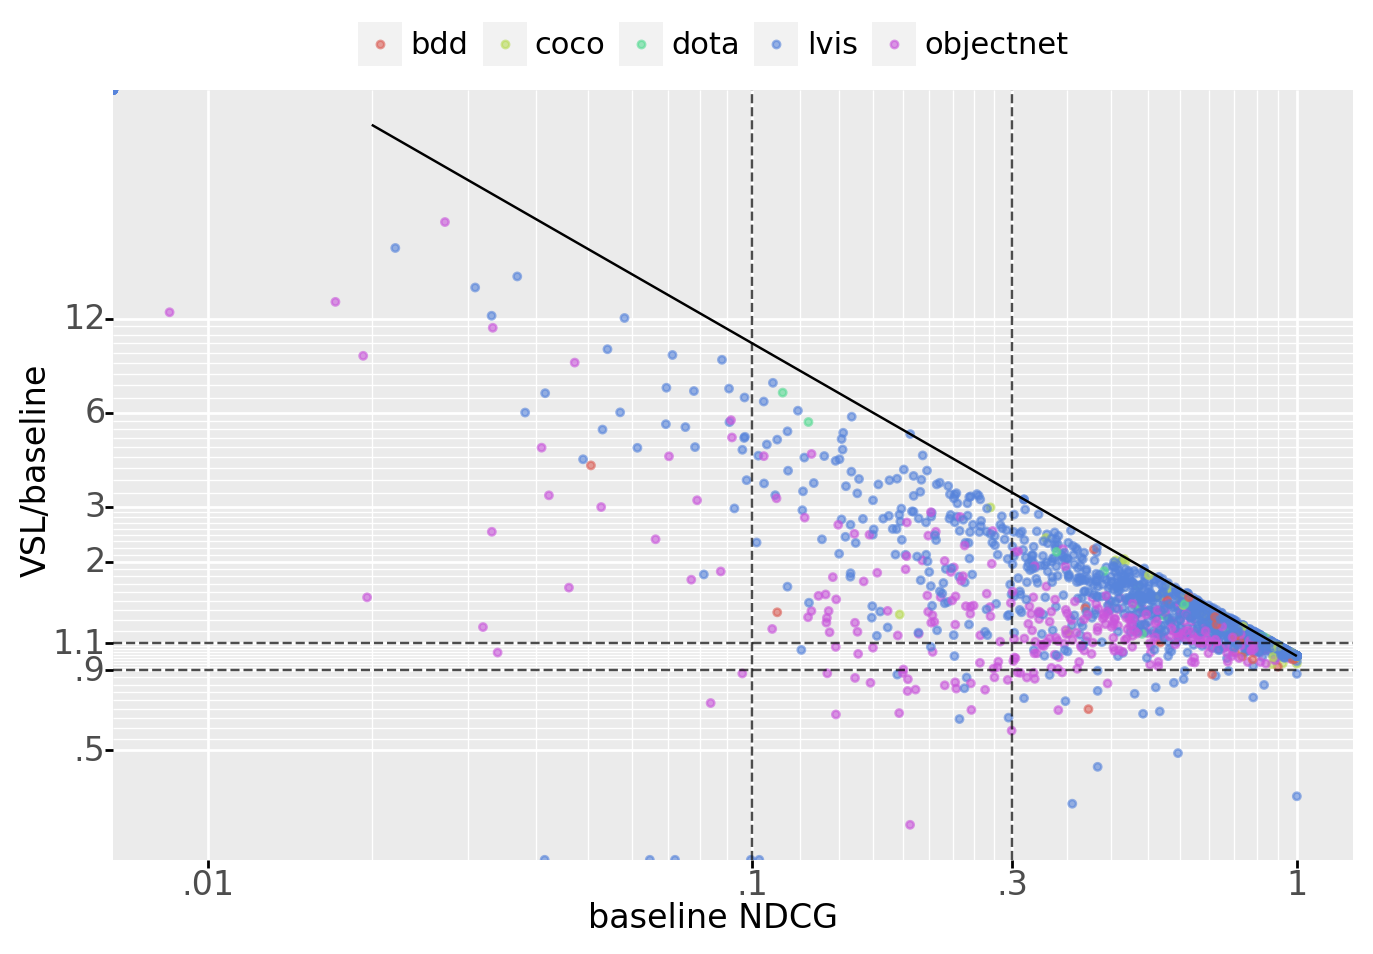

<ggplot: (8776779965076)>

In [56]:
print_tables(stats, variant='multiplain_warm_vec_fast')

by dataset


,multiplain,multiplain_warm_vec_fast,plain,num_queries
dataset,,,,
bdd,0.729821,0.817710,0.722601,29
coco,0.920811,0.950333,0.861299,80
dota,0.744009,0.849884,0.609752,15
lvis,0.709576,0.782842,0.618615,1202
objectnet,0.407760,0.497031,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,12,14,3,29
coco,23,56,1,80
dota,11,4,0,15
lvis,795,382,25,1202
objectnet,206,86,21,313
total,1047,542,50,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      12 &    14 &      3 &     29 \\
coco      &      23 &    56 &      1 &     80 \\
dota      &      11 &     4 &      0 &     15 \\
lvis      &     795 &   382 &     25 &   1202 \\
objectnet &     206 &    86 &     21 &    313 \\
total     &    1047 &   542 &     50 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.24,.43,.83
ratio,5.17,2.46,1.16


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .24 &  .43 &  .83 \\
ratio     & 5.17 & 2.46 & 1.16 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.35,.17,.76,.05
+ feedback fusion,.24,.16,.43,.08,.83,.07


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .35 &       .17 & .76 &       .05 \\
+ feedback fusion   & .24 &       .16 & .43 &       .08 & .83 &       .07 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.081066,0.034642,0.346064,0.170676,0.763686,0.045771
+ feedback fusion,0.239996,0.158930,0.430678,0.084614,0.834828,0.071142


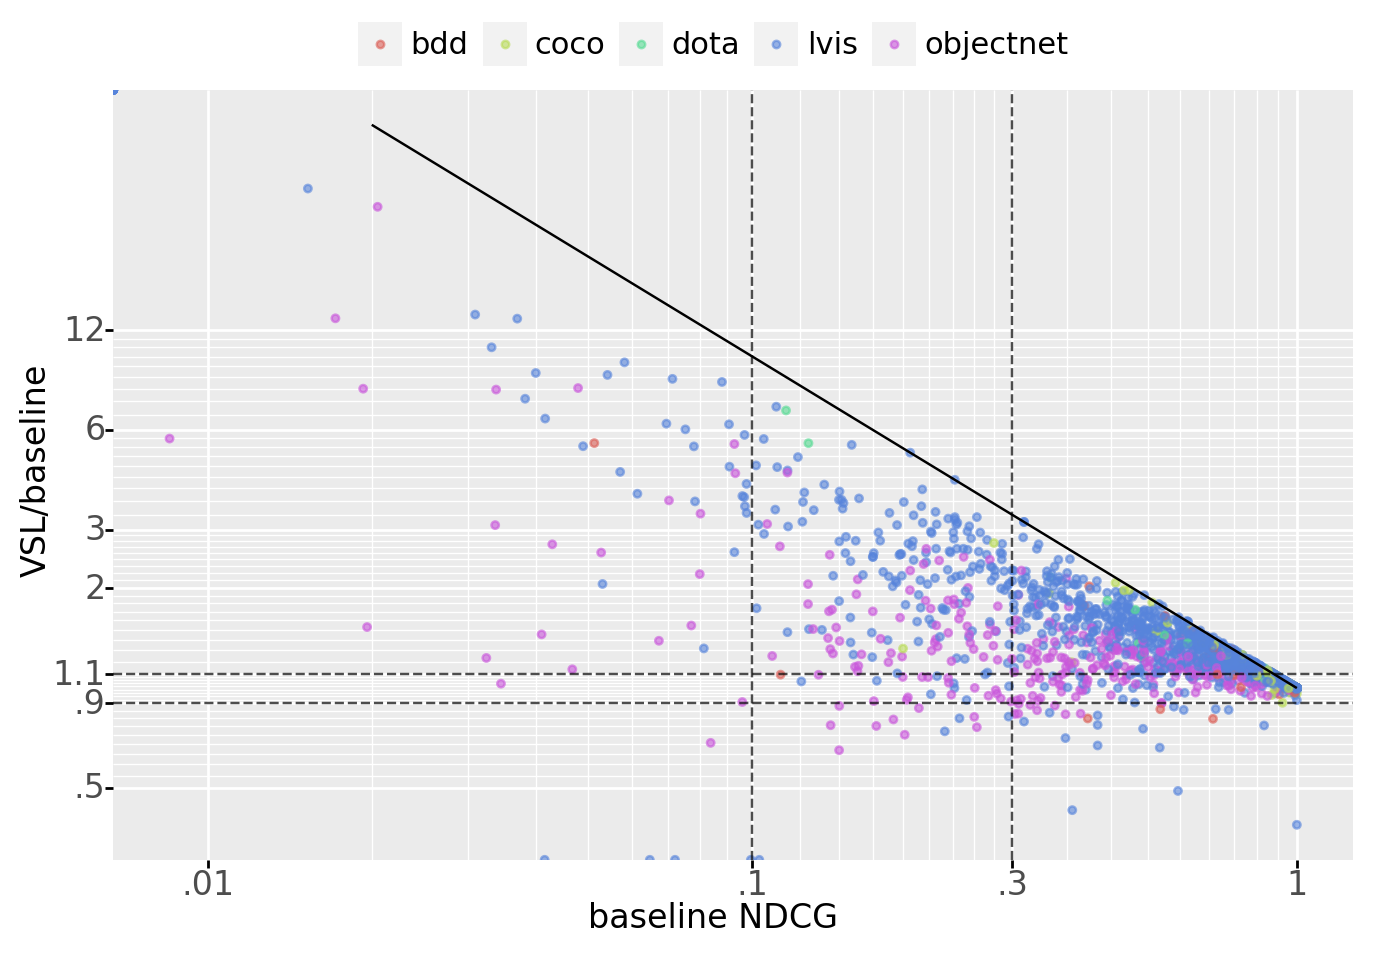

<ggplot: (8758098983021)>

In [199]:
print_tables(stats, variant='multiplain_warm_vec_fast')

by dataset


,multiplain,multiplain_warm_vec_fast,multiplain_warm_vec_fast_new,multiplain_warm_vec_only,plain,num_queries
dataset,,,,,,
bdd,0.729813,0.822550,0.826815,0.795368,0.722601,29
coco,0.920710,0.950331,0.953270,0.951207,0.861299,80
dota,0.743803,0.848598,0.879872,0.842240,0.609752,15
lvis,0.709576,0.787186,0.779060,0.766907,0.618615,1202
objectnet,0.407760,0.497550,0.496712,0.473783,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,15,11,3,29
coco,22,58,0,80
dota,11,4,0,15
lvis,765,407,30,1202
objectnet,210,84,19,313
total,1023,564,52,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      15 &    11 &      3 &     29 \\
coco      &      22 &    58 &      0 &     80 \\
dota      &      11 &     4 &      0 &     15 \\
lvis      &     765 &   407 &     30 &   1202 \\
objectnet &     210 &    84 &     19 &    313 \\
total     &    1023 &   564 &     52 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.24,.44,.84
ratio,5.13,2.49,1.17


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .24 &  .44 &  .84 \\
ratio     & 5.13 & 2.49 & 1.17 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.35,.17,.76,.05
+ feedback fusion,.24,.16,.44,.09,.84,.08


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .35 &       .17 & .76 &       .05 \\
+ feedback fusion   & .24 &       .16 & .44 &       .09 & .84 &       .08 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.081066,0.034642,0.346063,0.170675,0.763616,0.045701
+ feedback fusion,0.238081,0.157015,0.436127,0.090064,0.843130,0.079514


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


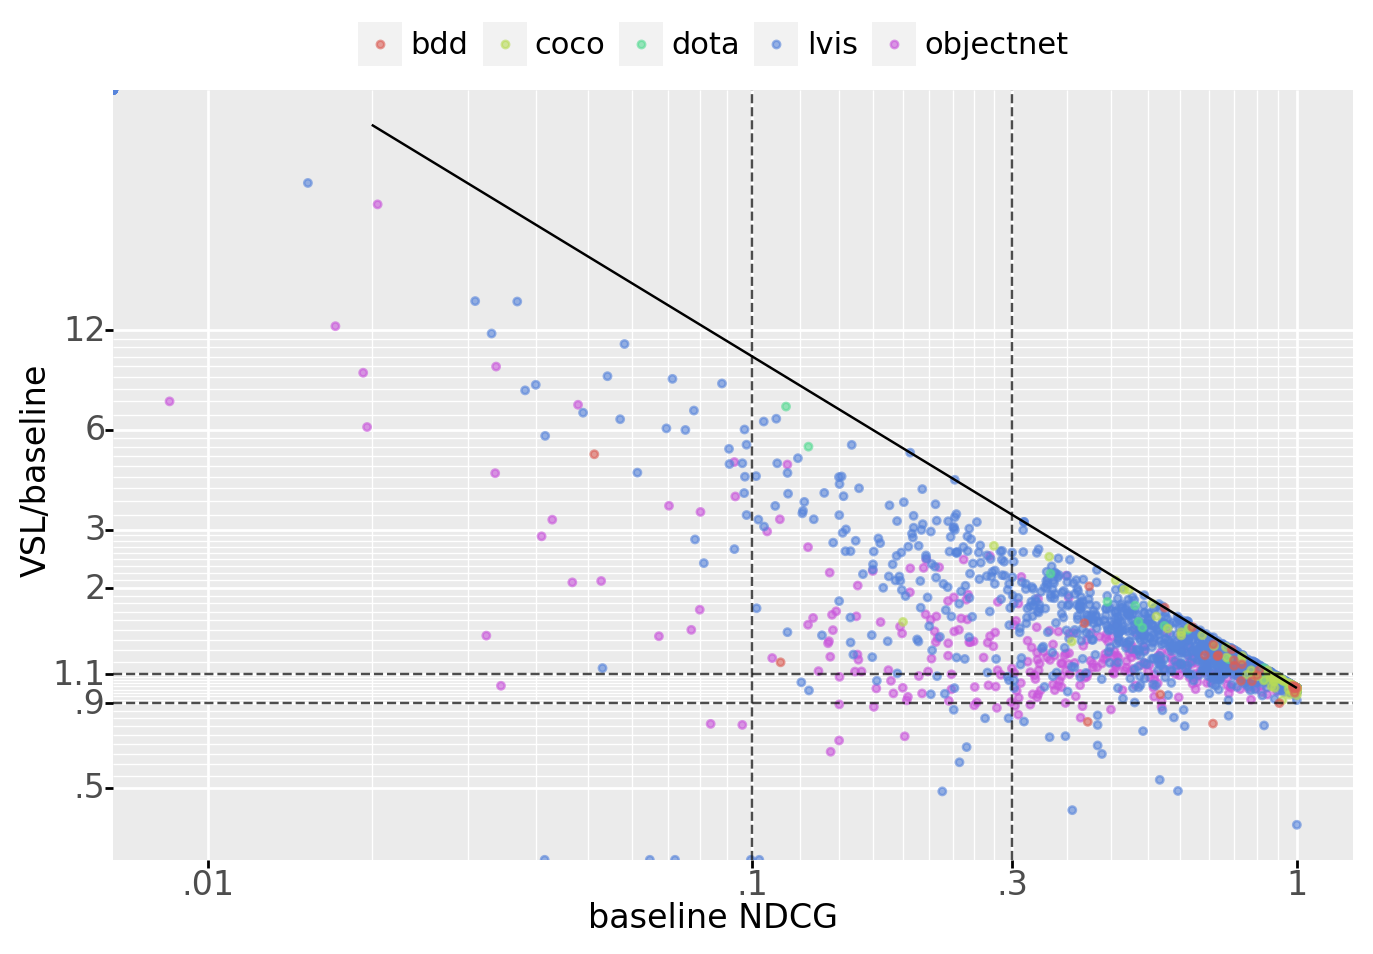

<ggplot: (8736542639541)>

In [101]:
print_tables(evs2, variant='multiplain_warm_vec_fast_new', resultlist=results, at_N=100)

In [ ]:
Out[101]

by dataset


,multiplain,multiplain_warm_vec_fast,multiplain_warm_vec_only,plain,num_queries
dataset,,,,,
bdd,0.729813,0.822550,0.795368,0.722601,29
coco,0.920710,0.950331,0.951207,0.861299,80
dota,0.743803,0.848598,0.842240,0.609752,15
lvis,0.709576,0.787186,0.766907,0.618615,1202
objectnet,0.407760,0.497550,0.473783,0.407660,313


by query


,better,same,worse,total
dataset,,,,
bdd,14,12,3,29
coco,23,56,1,80
dota,11,4,0,15
lvis,798,379,25,1202
objectnet,226,83,4,313
total,1072,534,33,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      14 &    12 &      3 &     29 \\
coco      &      23 &    56 &      1 &     80 \\
dota      &      11 &     4 &      0 &     15 \\
lvis      &     798 &   379 &     25 &   1202 \\
objectnet &     226 &    83 &      4 &    313 \\
total     &    1072 &   534 &     33 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.23,.43,.84
ratio,4.92,2.44,1.17


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .23 &  .43 &  .84 \\
ratio     & 4.92 & 2.44 & 1.17 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.08,.03,.35,.17,.76,.05
+ feedback fusion,.23,.15,.43,.08,.84,.07


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .08 &       .03 & .35 &       .17 & .76 &       .05 \\
+ feedback fusion   & .23 &       .15 & .43 &       .08 & .84 &       .07 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.081066,0.034642,0.346063,0.170675,0.763616,0.045701
+ feedback fusion,0.228424,0.147359,0.428486,0.082422,0.837575,0.073959


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


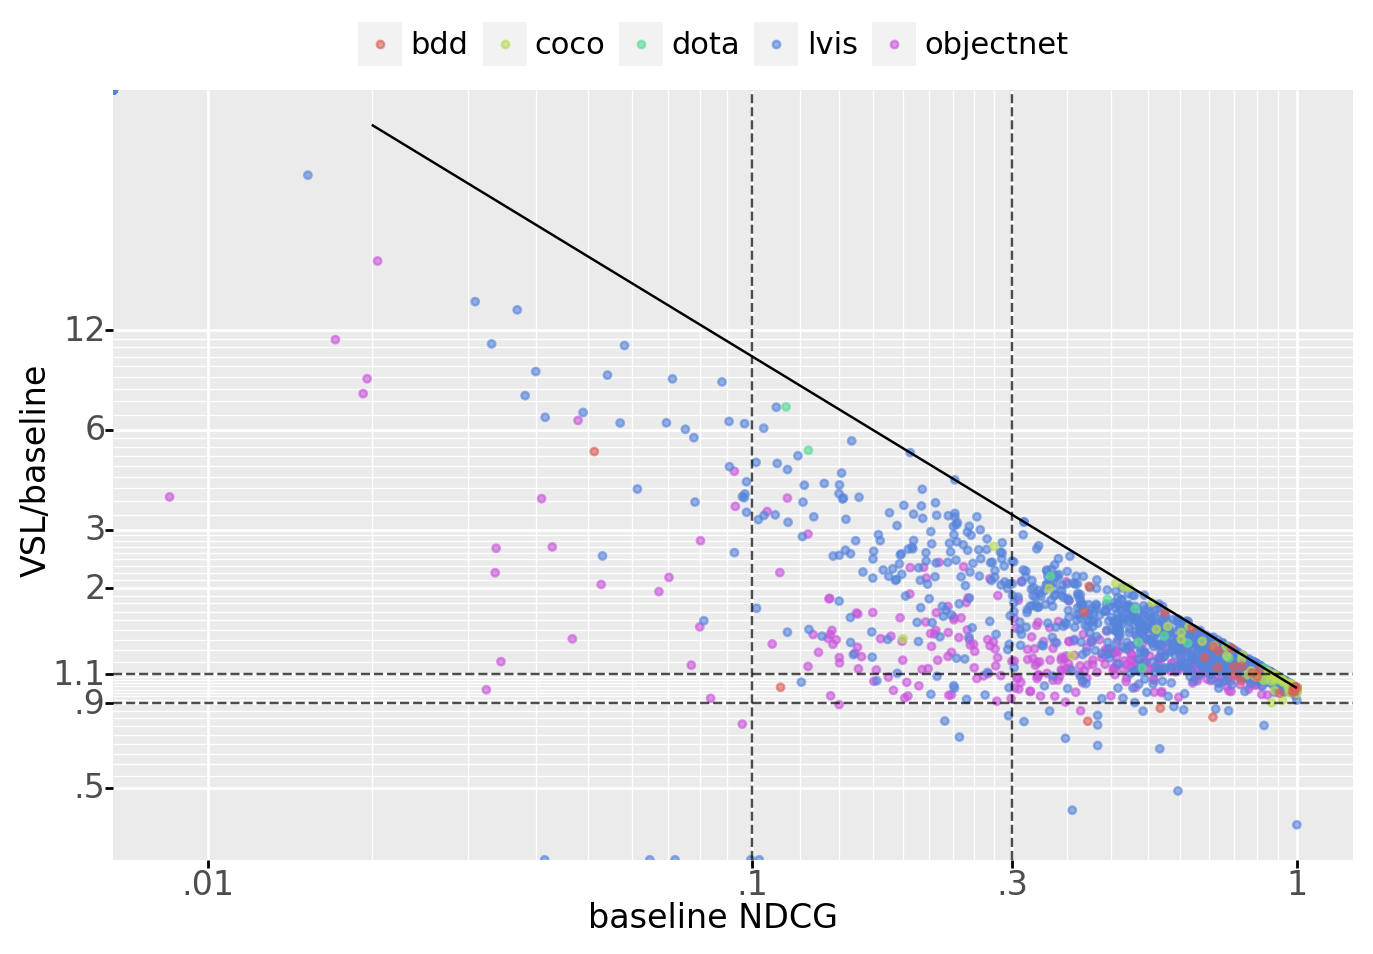

<ggplot: (8736544546747)>

In [78]:
print_tables(evs2, variant='multiplain_warm_vec_fast', resultlist=results, at_N=100)

by dataset


,multiplain,multiplain_warm_vec_fast,multiplain_warm_vec_only,plain,num_queries
dataset,,,,,
bdd,0.749163,0.815431,0.772148,0.753351,29
coco,0.939736,0.949559,0.948410,0.900086,80
dota,0.842396,0.893915,0.875208,0.710243,15
lvis,0.711823,0.757161,0.732191,0.616601,1202
objectnet,0.532907,0.567092,0.543957,0.532610,313


by query


,better,same,worse,total
dataset,,,,
bdd,11,15,3,29
coco,20,56,4,80
dota,7,8,0,15
lvis,702,469,31,1202
objectnet,108,200,5,313
total,848,748,43,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      11 &    15 &      3 &     29 \\
coco      &      20 &    56 &      4 &     80 \\
dota      &       7 &     8 &      0 &     15 \\
lvis      &     702 &   469 &     31 &   1202 \\
objectnet &     108 &   200 &      5 &    313 \\
total     &     848 &   748 &     43 &   1639 \\
\bottomrule
\end{tabular}

breakdown by initial res
total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,132,218,1289
baseline,.03,.22,.78
this work,.16,.47,.86
ratio,5.15,2.15,1.09


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &  132 &  218 & 1289 \\
baseline  &  .03 &  .22 &  .78 \\
this work &  .16 &  .47 &  .86 \\
ratio     & 5.15 & 2.15 & 1.09 \\
\bottomrule
\end{tabular}

ablation


part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.03,NaN,.22,NaN,.78,NaN
+ multiscale search,.09,.05,.43,.21,.82,.04
+ feedback fusion,.16,.08,.47,.04,.86,.04


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .03 &       NaN & .22 &       NaN & .78 &       NaN \\
+ multiscale search & .09 &       .05 & .43 &       .21 & .82 &       .04 \\
+ feedback fusion   & .16 &       .08 & .47 &       .04 & .86 &       .04 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.031575,NaN,0.219541,NaN,0.78315,NaN
+ multiscale search,0.085697,0.054122,0.427056,0.207514,0.81964,0.03649
+ feedback fusion,0.162513,0.076815,0.471125,0.044070,0.85609,0.03645


/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 32 rows containing missing values.


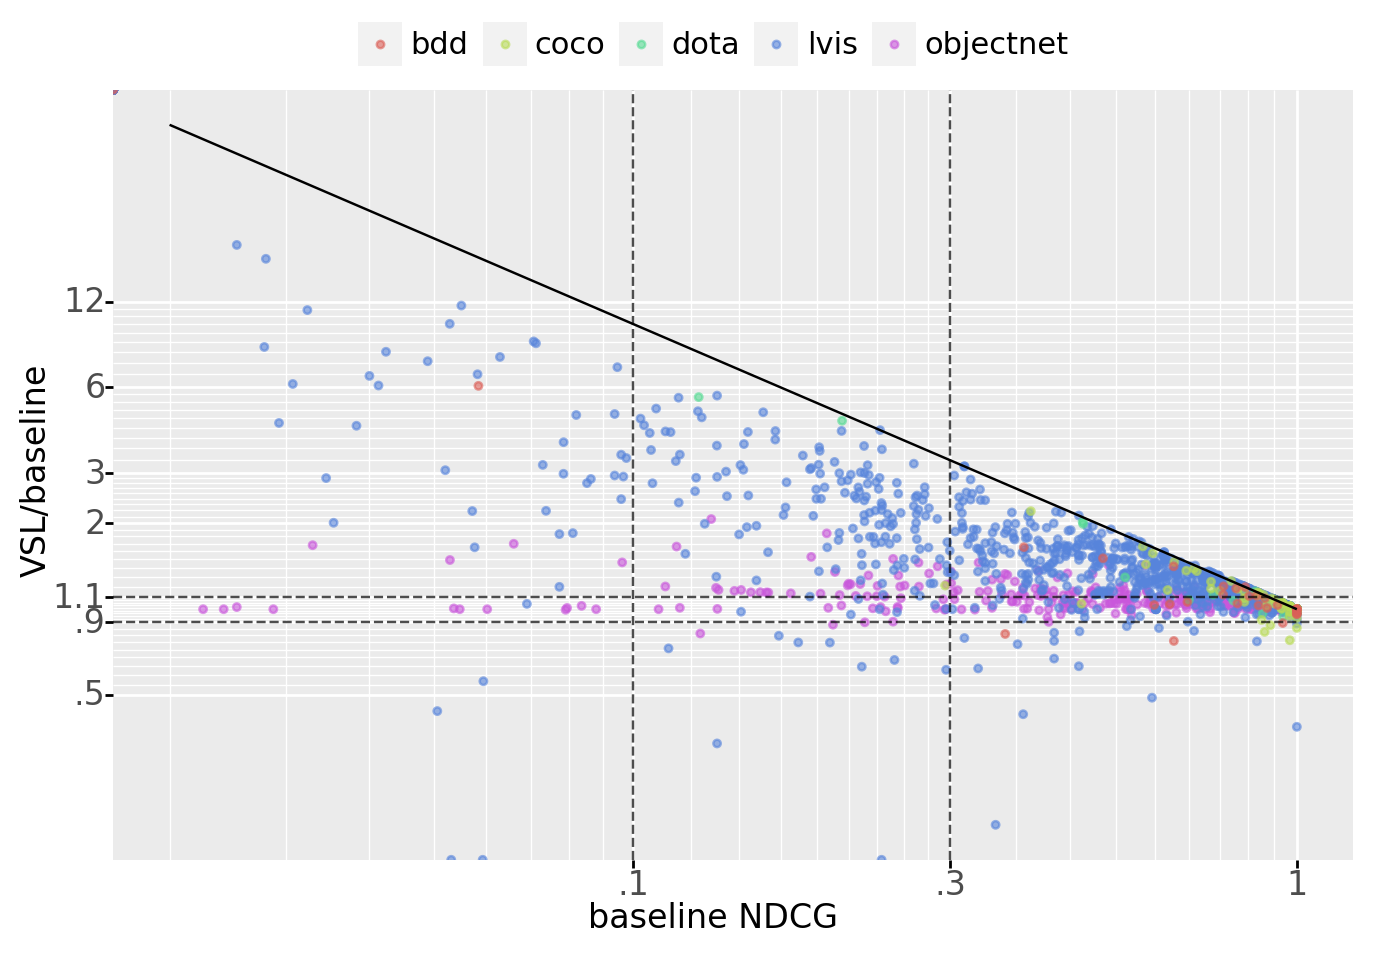

<ggplot: (8736544543169)>

In [77]:
print_tables(evs2, variant='multiplain_warm_vec_fast', resultlist=results, at_N=30)

In [90]:
stats = process_tups(evs=evs2, keys=evs.keys(), benchresults=benchresults, at_N=100)
all_vars = stats.groupby(['dataset', 'category', 'variant',]).ndcg_score.mean().unstack(-1)
means = all_vars.groupby('dataset').mean()
counts = all_vars.groupby('dataset').size()
pd.concat([means, counts],axis=1)

,multiplain,multiplain_warm_vec_only,plain,0
dataset,,,,
bdd,0.724021,0.796983,0.722364,29
coco,0.910035,0.946209,0.861293,80
dota,0.753675,0.855191,0.609754,15
lvis,0.709812,0.767466,0.618817,1202
objectnet,0.404891,0.472348,0.407764,313


In [62]:
stats = process_tups(evs=evs2, keys=evs.keys(), benchresults=benchresults, at_N=100)
all_vars = stats.groupby(['dataset', 'category', 'variant',]).ndcg_score.mean().unstack(-1)
means = all_vars.groupby('dataset').mean()
counts = all_vars.groupby('dataset').size()
pd.concat([means, counts],axis=1)

,multiplain,multiplain_warm_vec_only,plain,0
dataset,,,,
bdd,0.724021,0.796983,0.722364,29
coco,0.910035,0.946209,0.861293,80
dota,0.753675,0.855191,0.609754,15
lvis,0.709812,0.767466,0.618817,1202
objectnet,0.404891,0.472348,0.407764,313


In [43]:
stats = process_tups(evs=evs2, keys=evs.keys(), benchresults=benchresults, at_N=100)
all_vars = stats.groupby(['dataset', 'category', 'variant',]).ndcg_score.mean().unstack(-1)
means = all_vars.groupby('dataset').mean()
counts = all_vars.groupby('dataset').size()
pd.concat([means, counts],axis=1)

,multiplain,multiplain_warm_vec_only,plain,0
dataset,,,,
bdd,0.724435,0.793867,0.722601,29
coco,0.910082,0.944175,0.861299,80
dota,0.753533,0.852066,0.609752,15
lvis,0.709576,0.763332,0.618615,1202
objectnet,0.404909,0.472402,0.407660,313


In [32]:
bsw_table(stats, reltol=1.1)

,better,same,worse,total
dataset,,,,
bdd,12,13,4,29
coco,25,54,1,80
dota,12,3,0,15
lvis,757,411,34,1202
objectnet,203,109,1,313
total,1009,590,40,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      12 &    13 &      4 &     29 \\
coco      &      25 &    54 &      1 &     80 \\
dota      &      12 &     3 &      0 &     15 \\
lvis      &     757 &   411 &     34 &   1202 \\
objectnet &     203 &   109 &      1 &    313 \\
total     &    1009 &   590 &     40 &   1639 \\
\bottomrule
\end{tabular}



In [65]:
bsw_table(stats, reltol=1.1)

,better,same,worse,total
dataset,,,,
bdd,12,13,4,29
coco,25,55,0,80
dota,12,3,0,15
lvis,762,405,35,1202
objectnet,198,114,2,314
total,1009,590,41,1640


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      12 &    13 &      4 &     29 \\
coco      &      25 &    55 &      0 &     80 \\
dota      &      12 &     3 &      0 &     15 \\
lvis      &     762 &   405 &     35 &   1202 \\
objectnet &     198 &   114 &      2 &    314 \\
total     &    1009 &   590 &     41 &   1640 \\
\bottomrule
\end{tabular}



In [48]:
bsw_table(stats, reltol=1.1)

,better,same,worse,total
dataset,,,,
bdd,12,13,4,29
coco,25,55,0,80
dota,12,3,0,15
lvis,745,423,34,1202
objectnet,202,110,1,313
total,996,604,39,1639


\begin{tabular}{lrrrr}
\toprule
{} &  better &  same &  worse &  total \\
dataset   &         &       &        &        \\
\midrule
bdd       &      12 &    13 &      4 &     29 \\
coco      &      25 &    55 &      0 &     80 \\
dota      &      12 &     3 &      0 &     15 \\
lvis      &     745 &   423 &     34 &   1202 \\
objectnet &     202 &   110 &      1 &    313 \\
total     &     996 &   604 &     39 &   1639 \\
\bottomrule
\end{tabular}



In [108]:
bsw = bsw_table(stats)

,better,same,worse
dataset,,,
bdd_10k_supercloud,15,11,3
coco_10k_supercloud,43,37,0
dota_10k_supercloud,10,5,0
lvis_10k_supercloud,314,558,79
objectnet_10k_supercloud,145,156,12
total,527,767,94


\begin{tabular}{lrrr}
\toprule
{} &  better &  same &  worse \\
dataset                  &         &       &        \\
\midrule
bdd\_10k\_supercloud       &      15 &    11 &      3 \\
coco\_10k\_supercloud      &      43 &    37 &      0 \\
dota\_10k\_supercloud      &      10 &     5 &      0 \\
lvis\_10k\_supercloud      &     314 &   558 &     79 \\
objectnet\_10k\_supercloud &     145 &   156 &     12 \\
total                    &     527 &   767 &     94 \\
\bottomrule
\end{tabular}



In [49]:
from seesaw 

In [ ]:
sbs = better_same_worse(stats, variant='multiplain_warm_vec_only', summary=False)

In [82]:
tot_res = summary_breakdown(sbs)
#.groupby(['dataset', 'variant']).category.apply(lambda x : x.unique().shape[0]).unstack(level=-1)

In [74]:
comparison_table(tot_res)

total_counts:  1639.0


part,.1,.3,1.
variant,,,
counts,86,250,1303
baseline,.05,.18,.72
this work,.10,.39,.83
ratio,2.11,2.22,1.15


\begin{tabular}{lrrr}
\toprule
part &   .1 &   .3 &   1. \\
variant   &      &      &      \\
\midrule
counts    &   86 &  250 & 1303 \\
baseline  &  .05 &  .18 &  .72 \\
this work &  .10 &  .39 &  .83 \\
ratio     & 2.11 & 2.22 & 1.15 \\
\bottomrule
\end{tabular}



part,.1,.3,1.
variant,,,
counts,86.000000,250.000000,1303.000000
baseline,0.046423,0.175388,0.717915
this work,0.098110,0.389813,0.827918
ratio,2.113379,2.222571,1.153226


In [79]:
ablation_table(tot_res)

part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,.05,NaN,.18,NaN,.72,NaN
+ multiscale search,.07,.03,.33,.16,.76,.04
+ feedback fusion,.10,.02,.39,.06,.83,.07


\begin{tabular}{lrrrrrr}
\toprule
part &  .1 &  .1 delta &  .3 &  .3 delta &  1. &  1. delta \\
variant             &     &           &     &           &     &           \\
\midrule
semantic embeddding & .05 &       NaN & .18 &       NaN & .72 &       NaN \\
+ multiscale search & .07 &       .03 & .33 &       .16 & .76 &       .04 \\
+ feedback fusion   & .10 &       .02 & .39 &       .06 & .83 &       .07 \\
\bottomrule
\end{tabular}



part,.1,.1 delta,.3,.3 delta,1.,1. delta
variant,,,,,,
semantic embeddding,0.046423,NaN,0.175388,NaN,0.717915,NaN
+ multiscale search,0.074560,0.028137,0.332714,0.157326,0.762769,0.044854
+ feedback fusion,0.098110,0.023550,0.389813,0.057099,0.827918,0.065149


In [84]:
ablation_table(tot_res)

,0.1,0.1 delta,0.3,0.3 delta,1.0,1.0 delta
variant,,,,,,
semantic embeddding,.06,NaN,.22,NaN,.68,NaN
+ multiscale search,.15,.09,.33,.11,.72,.05
+ feedback fusion,.23,.08,.40,.06,.76,.04


\begin{tabular}{lrrrrrr}
\toprule
{} &  0.1 &  0.1 delta &  0.3 &  0.3 delta &  1.0 &  1.0 delta \\
variant             &      &            &      &            &      &            \\
\midrule
semantic embeddding &  .06 &        NaN &  .22 &        NaN &  .68 &        NaN \\
+ multiscale search &  .15 &        .09 &  .33 &        .11 &  .72 &        .05 \\
+ feedback fusion   &  .23 &        .08 &  .40 &        .06 &  .76 &        .04 \\
\bottomrule
\end{tabular}



,0.1,0.1 delta,0.3,0.3 delta,1.0,1.0 delta
variant,,,,,,
semantic embeddding,0.059105,NaN,0.223374,NaN,0.677310,NaN
+ multiscale search,0.147890,0.088785,0.334245,0.110871,0.722461,0.045151
+ feedback fusion,0.229589,0.081698,0.397158,0.062913,0.762536,0.040075


In [83]:
plotdata = sbs[sbs.variant == 'multiplain_warm_vec_only']

In [68]:
make_labeler.__module__

'seesaw.vls_benchmark_tools'

/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


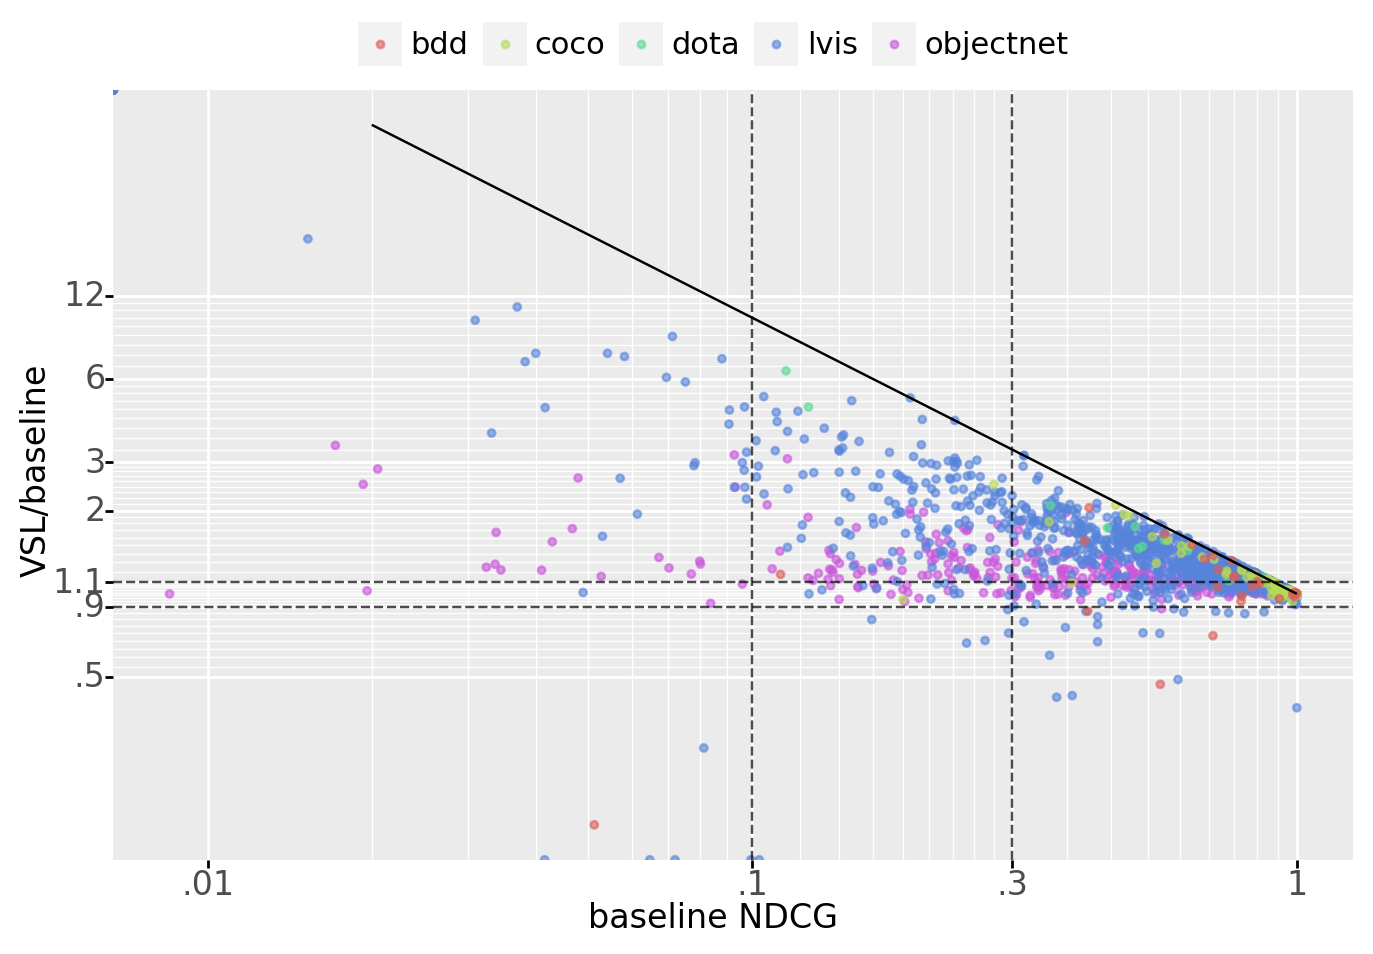

<ggplot: (8770274595410)>

In [84]:
ablation_table(tot_res)

x = np.geomspace(.02, 1, num=5)
y = 1/x
diag_df = pd.DataFrame({'x':x, 'y':y})

scatterplot = (ggplot(plotdata)
    + geom_point(aes(x='base', y='ratio', fill='dataset', color='dataset'), alpha=.6, size=1.) 
#                 shape=plotdata.dataset.map(lambda x : '.' if x in ['lvis','objectnet'] else 'o'), 
#                 size=plotdata.dataset.map(lambda x : 1. if x in ['lvis','objectnet'] else 2.))
#  + geom_text(aes(x='base', y='delta', label='category', color='dataset'), va='bottom', 
#              data=plotdata1[plotdata1.ratio < .6], 
#              position=position_jitter(.05, .05), show_legend=False)
    + geom_line(aes(x='x', y='y'), data=diag_df)
 + ylab('VSL/baseline')
#               + geom_area(aes(y2=1.1, y=.9), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=1.1), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=.9), linetype='dashed', alpha=.7)


                + geom_vline(aes(xintercept=.1,), linetype='dashed', alpha=.7)
                + geom_vline(aes(xintercept=.3,), linetype='dashed', alpha=.7)
#+ geom_abline()
#    + geom_point(aes(x='recall', y='precision', color='variant'), size=1.)
#     + facet_wrap(facets=['cat'], ncol=6, scales='free_x')
 + xlab('baseline NDCG')
# +scale_color_discrete()
    + theme(figure_size=(8,5), legend_position='top',
           subplots_adjust={'hspace': 0.5}, legend_title=element_blank(),
            legend_box_margin=-1, legend_margin=0.,
            axis_text=element_text(size=12, margin={'t':.2, 'l':-.3}),
            legend_text=element_text(size=11),
            axis_title=element_text(size=12, margin={'r':-.2, 'b':0., 'l':0, 't':0.}),
           )
    + scale_x_log10(labels=make_labeler(brief_format), breaks=[.01, .1, .3, 1.])
    + scale_y_log10(labels=make_labeler(brief_format), breaks=[.5, 0.9, 1.1, 2., 3.,6, 12])
)

scatterplot

In [87]:
scatterplot.save('/home/gridsan/omoll/seesaw.scatterfull.png')

/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 5 in image.
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: /home/gridsan/omoll/seesaw.scatterfull.png
/home/gridsan/omoll/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/home/gridsan/omoll/.local/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 12 rows containing missing values.


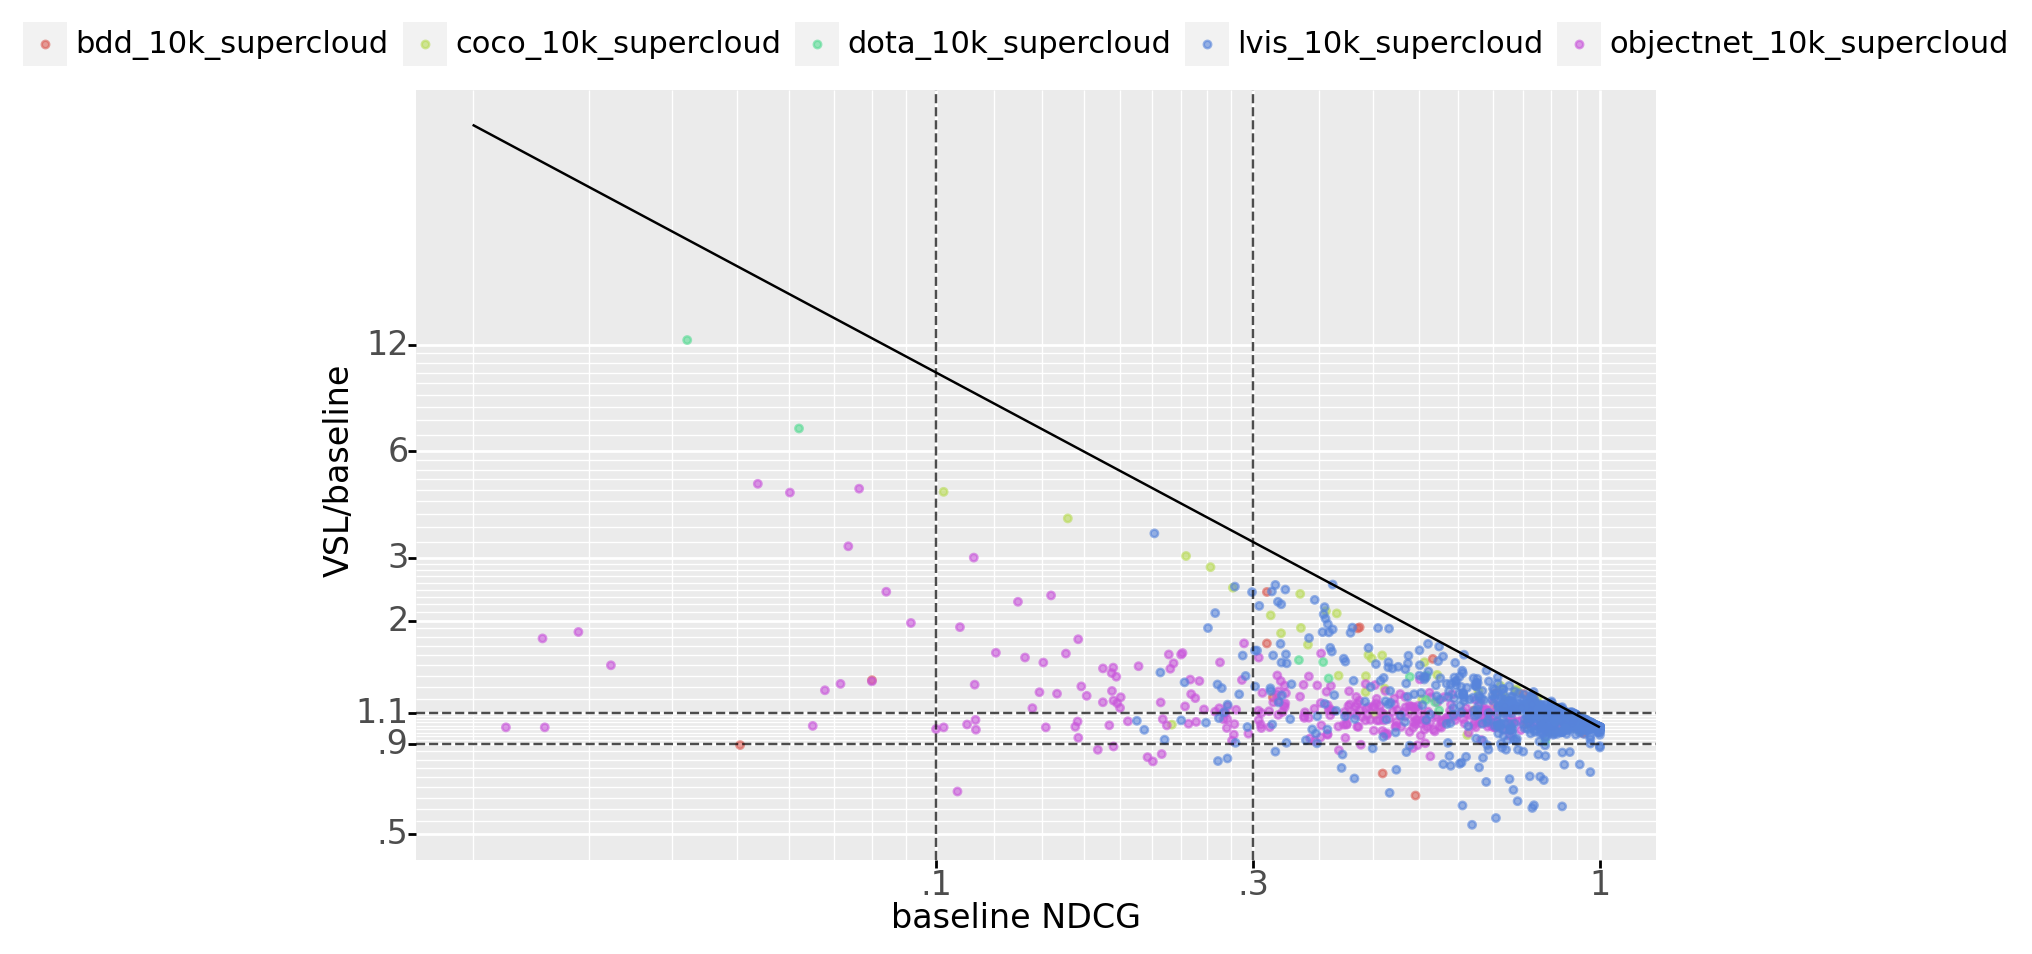

<ggplot: (8772441836517)>

In [91]:
x = np.geomspace(.02, 1, num=5)
y = 1/x
diag_df = pd.DataFrame({'x':x, 'y':y})

scatterplot = (ggplot(plotdata)
    + geom_point(aes(x='base', y='ratio', fill='dataset', color='dataset'), alpha=.6, size=1.) 
#                 shape=plotdata.dataset.map(lambda x : '.' if x in ['lvis','objectnet'] else 'o'), 
#                 size=plotdata.dataset.map(lambda x : 1. if x in ['lvis','objectnet'] else 2.))
#  + geom_text(aes(x='base', y='delta', label='category', color='dataset'), va='bottom', 
#              data=plotdata1[plotdata1.ratio < .6], 
#              position=position_jitter(.05, .05), show_legend=False)
    + geom_line(aes(x='x', y='y'), data=diag_df)
 + ylab('VSL/baseline')
#               + geom_area(aes(y2=1.1, y=.9), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=1.1), linetype='dashed', alpha=.7)
               + geom_hline(aes(yintercept=.9), linetype='dashed', alpha=.7)


                + geom_vline(aes(xintercept=.1,), linetype='dashed', alpha=.7)
                + geom_vline(aes(xintercept=.3,), linetype='dashed', alpha=.7)
#+ geom_abline()
#    + geom_point(aes(x='recall', y='precision', color='variant'), size=1.)
#     + facet_wrap(facets=['cat'], ncol=6, scales='free_x')
 + xlab('baseline NDCG')
# +scale_color_discrete()
    + theme(figure_size=(8,5), legend_position='top',
           subplots_adjust={'hspace': 0.5}, legend_title=element_blank(),
            legend_box_margin=-1, legend_margin=0.,
            axis_text=element_text(size=12, margin={'t':.2, 'l':-.3}),
            legend_text=element_text(size=11),
            axis_title=element_text(size=12, margin={'r':-.2, 'b':0., 'l':0, 't':0.}),
           )
    + scale_x_log10(labels=make_labeler(brief_format), breaks=[.01, .1, .3, 1.])
    + scale_y_log10(labels=make_labeler(brief_format), breaks=[.5, 0.9, 1.1, 2., 3.,6, 12])
)

scatterplot

In [259]:
cats = plotdata[plotdata.dataset == 'lvis'].sort_values('nfirst_y', ascending=False)[['category', 'nfirst_x', 'nfirst_y']].reset_index(drop=True)

In [260]:
cats.to_parquet('./data/cats_lvis_ordered.parquet')

In [265]:
sbs[(sbs.nfirst_x <= 5) & (sbs.nfirst_y > 20) & (sbs.variant == 'multiplain_warm_vec_only')]

,dataset,category,variant,ntotal,abundance,nfirst_x,ndcg_score,nfound_x,nfirst_y,base_ndcg_score,nfound_y,base,ratio,delta,better,worse,same
368,dota,helicopter,multiplain_warm_vec_only,23,0.023000,2.0,0.539886,18,30.0,0.069854,3,0.069854,7.728784,0.470032,True,False,False
394,lvis,bow (weapon),multiplain_warm_vec_only,8,0.007175,3.0,0.337481,4,26.0,0.134289,3,0.134289,2.513096,0.203192,True,False,False
464,lvis,checkerboard,multiplain_warm_vec_only,4,0.005988,5.0,0.341658,4,36.0,0.137418,2,0.137418,2.486260,0.204239,True,False,False
524,lvis,drill,multiplain_warm_vec_only,21,0.020751,2.0,0.454678,15,22.0,0.075560,3,0.075560,6.017413,0.379117,True,False,False
1133,lvis,cornmeal,multiplain_warm_vec_only,1,0.004878,5.0,0.386853,1,32.0,0.198240,1,0.198240,1.951438,0.188613,True,False,False
1136,lvis,hammer,multiplain_warm_vec_only,33,0.032227,3.0,0.417670,18,25.0,0.091993,5,0.091993,4.540219,0.325677,True,False,False
1355,lvis,mint candy,multiplain_warm_vec_only,12,0.011858,1.0,0.556627,10,29.0,0.071541,2,0.071541,7.780547,0.485086,True,False,False
1487,lvis,cape,multiplain_warm_vec_only,26,0.023111,1.0,0.705236,21,21.0,0.179671,8,0.179671,3.925145,0.525565,True,False,False
1706,lvis,hornet,multiplain_warm_vec_only,1,0.004902,1.0,1.000000,1,inf,0.000000,0,0.000000,inf,1.000000,True,False,False
1964,lvis,hot-air balloon,multiplain_warm_vec_only,3,0.005386,1.0,0.716014,3,34.0,0.091490,1,0.091490,7.826131,0.624524,True,False,False


In [267]:
# hot air balloon